In [1]:
import seaborn as sns
import pandas as pd
import pylab as plt
import numpy as np
import time
import os
import glob
import json
import tensorflow as tf
import sys
from IPython import display
from riotwatcher import RiotWatcher
import requests

api_file = os.path.join('..','..','apikeys','LOL_api_key.txt')
with open(api_file, 'r') as fin:
    watcher = RiotWatcher(fin.readline())

# Get matchids for challenger tier players
because there is no api call to just get a bunch matches I have to do some weird stuff. My strategy is: get challenger player list from the region -> getsummoner by playerid to get accountid -> get recent matches from each player -> check duplicates -> get match details

also can swap challenger to masters p easy. swapping to lower leagues is a bit harder


In [26]:
#regions = ['RU','KR', 'BR1', 'OC1', 'JP1', 'NA1', 'EUN1', 'EUW1', 'TR1', 'LA1', 'LA2']
regions = ['KR', 'BR1', 'OC1', 'JP1', 'NA1', 'EUN1', 'EUW1', 'TR1', 'LA1', 'LA2']
regions = regions[::-1]
print(regions)
#gameid_list = {}
league_items = {}

#choose tier, division, and queue
#for tier lower than master need to get league codes then get league items
#valid tiers CHALLENGER, MASTERS, DIAMOND, PLATINUM, GOLD, SILVER, BRONZE, IRON
#valid divisions I, II, III, IV
tier = 'MASTERS'
division = 'I'
queue = 'RANKED_SOLO_5x5'

#get last challenger games for each player in each region (purge duplicates)
#first loop through regions
for region in regions:
    league_items[region] = []
    
    #get all 'items' in the challenger league for solo queue (not sure about 'flex' queues?)
    #changed to master tier because that is the highest until mid january
    if tier=='CHALLENGER':
        league_items[region] = watcher.league.challenger_by_queue(region, queue)['entries']
    elif tier=='MASTERS':
        league_items[region] = watcher.league.masters_by_queue(region,queue)['entries']
    else:
        #this entries method doesn't exist yet (as of 20190428)
        league_codes = watcher.league.entries(region, 'RANKED_SOLO_5x5',tier)
        for league in league_codes:
                leagues_items[region].append(watcher.league.by_id(region,league)['entries'])

    #initialize gameid_list items
    gameid_list[region] = []

#loop through all items in each region's league to get matchid's
for region in regions:
    print(region)

    #get 100 matches from each player  
    for entry in league_items[region]:

        #convert player_id(aka summoner_id) to account_id
        account_id = watcher.summoner.by_id(region, entry['summonerId'])['accountId']

        #don't keep all matches in memory or on disk - we will get full match details later
        #queue = 420 is the code for 5x5_solo_queue
        match_list = watcher.match.matchlist_by_account(region,
                                     account_id,
                                     queue=420,
                                     begin_index = 1,
                                     end_index=100)['matches']
        match_list = watcher.match.matchlist_by_account(region,
                                    account_id,
                                    queue=420,
                                    begin_index=101,
                                    end_index=200)['matches'] 
        match_list = watcher.match.matchlist_by_account(region,
                                    account_id,
                                    queue=420,
                                    begin_index=201,
                                    end_index=300)['matches']
        #keep gameid_list in memory for later use and for easy purging of duplicates
        for match in match_list:
            gameid_list[region].append(match['gameId']) 

   #purge duplicates from gameid_list
        gameid_list[region] = list(set(gameid_list[region]))

       

['LA2', 'LA1', 'TR1', 'EUW1', 'EUN1', 'NA1', 'JP1', 'OC1', 'BR1', 'KR']
LA2
LA1
TR1
EUW1
EUN1
NA1
JP1
OC1
BR1
KR


In [27]:
with open(os.path.join('LOL_data',str(tier)+'_tier','saved'+time.strftime('%Y-%m-%d')+'.json'), 'w') as fp:
    json.dump(gameid_list, fp)

# Get match details

## Load data into dataframe
Do this from a file. Also reindex DF so that we can hopefully call each region in a mixed rather than sequential way

In [28]:
#get all files in challenger_tier data folder, then sort by date
files = glob.glob(os.path.join('LOL_data',tier+'_tier','*.json'))
files.sort(key=os.path.getmtime)
print(files)

['LOL_data/MASTERS_tier/saved2019-04-10.json', 'LOL_data/MASTERS_tier/saved2019-05-17.json']


In [29]:
lol_df = pd.DataFrame()
region_list = []
gameid_load_list = []

with open(files[-1],'r') as fp:
    for key, item in json.load(fp).items():
        region_list.extend([key] * len(item))
        gameid_load_list.extend(item)
        
lol_df['region'] = region_list
lol_df['gameid'] = gameid_load_list
lol_df.describe()

,gameid
count,3.484320e+05
mean,2.648800e+09
std,1.263065e+09
min,1.372199e+08
25%,1.586037e+09
50%,3.020563e+09
75%,3.638965e+09
max,4.021673e+09


In [30]:
lol_df_prev = pd.DataFrame()
region_list_prev = []
gameid_load_list_prev = []

#load second most recent data file to check duplicates
with open(files[-2],'r') as fp:
    for key, item in json.load(fp).items():
        region_list_prev.extend([key] * len(item))
        gameid_load_list_prev.extend(item)

#drop duplicates
#this is definitely an inefficient way to do it, but idk how to do it better
for region,gameid in zip(region_list_prev,gameid_load_list_prev):
    duplicate = lol_df.loc[lol_df['region']==region]
    duplicate = duplicate.loc[duplicate['gameid']==gameid]
    if len(duplicate!=0):
        lol_df.drop(duplicate.index,inplace=True)
lol_df.describe

<bound method NDFrame.describe of        region     gameid
0          RU  207626240
1          RU  208035841
2          RU  200409093
3          RU  179937286
4          RU  205537288
5          RU  163667978
6          RU  178061327
7          RU  204619794
8          RU  185253906
9          RU  196952083
10         RU  206225431
11         RU  170876957
12         RU  187703326
13         RU  193560606
14         RU  166379552
15         RU  175448099
16         RU  172040235
17         RU  204513326
18         RU  198000686
19         RU  205111345
20         RU  178036787
21         RU  176799796
22         RU  199819329
23         RU  176898113
24         RU  200499268
25         RU  151830600
26         RU  184721483
27         RU  172376140
28         RU  195223629
29         RU  174923855
...       ...        ...
348402    LA2  451084216
348403    LA2  680427455
348404    LA2  669056960
348405    LA2  651460548
348406    LA2  664633286
348407    LA2  649691079
348408    LA2  6

In [31]:
#reindex randomly so that we don't loop through regions sequentially
#this way we more efficiently use the api calls we're allotted
lol_df = lol_df.reindex(np.random.permutation(lol_df.index))

## Get match details from riotwatcher api

In [ ]:
blue_win = []
red_gold = []
blue_gold = []
blue_tower_kills=[]
red_tower_kills=[]
blue_inhibitor_kills=[]
red_inhibitor_kills=[]
blue_baron_kills=[]
red_baron_kills=[]
blue_dragon_kills=[]
red_dragon_kills=[]
blue_champs = []
red_champs = []
bad_element_list = []
region_list = []
gameid_list = []
for i,row in lol_df[:].iterrows():
    
    #NOTE: Summoner spell info is included in match_details but may be hard to keep linked to participants
    #NOTE 2: Timeline info. can give timeline info on many things for teams and individual participants
    #   this could be used for training  a real time win probability model.
    try:
        match_details = watcher.match.by_id(row['region'],row['gameid'])   
    except requests.exceptions.HTTPError as err:
        print(err)
        print('Error at row:',row['gameid'])
        print('element:',i)
        bad_element_list.append(i)
        continue
        
    #skip element and mark as bad element if not 10 team members
    if len(match_details['participants'])!=10:
        bad_element_list.append(i)
        continue
    #append region_list and gameid_list so we don't have to
    #deal with wrong bad region, gameid
    region_list.append(row['region'])
    gameid_list.append(row['gameid'])
    
    #blue win is true if teamid=100 (blue) and this same team won
    blue_win.append(int(match_details['teams'][0]['win']=='Win' and match_details['teams'][0]['teamId']==100))

    #add blue gold and red gold (at end of match) to lists
    #intention for this is to take the difference then normalize by the total (to control for long vs. short games)
    blue_gold_match = 0
    red_gold_match = 0

    for participant in match_details['participants']:
        if participant['teamId']==100:
            blue_gold_match+=participant['stats']['goldEarned']
        else:
            red_gold_match+=participant['stats']['goldEarned']
    blue_gold.append(blue_gold_match)
    red_gold.append(red_gold_match)
    
    #add blue and red tower kills (at end of match) to lists
    #should take difference and normalize by the total towers
    try:
        blue_tower_kills.append(match_details['teams'][0]['towerKills'])
    except KeyError as err:
        print(err)
        print('Error at row:',row['gameid'])
        print('element:',i)
        bad_element_list.append(i)
        del region_list[-1]
        del gameid_list[-1]
        del blue_win_list[-1]
        del blue_gold[-1]
        del red_gold[-1]
        continue
    red_tower_kills.append(match_details['teams'][1]['towerKills'])
    
    #add blue and red tower kills (at end of match) to lists
    #should take difference and normalize by the total towers
    blue_inhibitor_kills.append(match_details['teams'][0]['inhibitorKills'])
    red_inhibitor_kills.append(match_details['teams'][1]['inhibitorKills'])
    
    #add blue and red tower kills (at end of match) to lists
    #like gold, should take diff and normalize
    blue_baron_kills.append(match_details['teams'][0]['baronKills'])
    red_baron_kills.append(match_details['teams'][1]['baronKills'])
    
    #add blue and red dragon kills (at end of match) to lists
    #like gold, the intention of this is to take the difference and normalize
    blue_dragon_kills.append(match_details['teams'][0]['dragonKills'])
    red_dragon_kills.append(match_details['teams'][1]['dragonKills'])

    #build team champion lineups and append to columns
    blue_champ_row = []
    red_champ_row = []
    for participant in match_details['participants']:
        if participant['teamId'] == 100:
            blue_champ_row.append(participant['championId'])
        elif participant['teamId'] ==200:
            red_champ_row.append(participant['championId'])
        else:
            print('Illegal team value!',participant['teamId'])
            break
    blue_champs.append(blue_champ_row)
    red_champs.append(red_champ_row)    

500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1636725019
Error at row: 1636725019
element: 97991
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3717709005
Error at row: 3717709005
element: 296956
503 Server Error: Service Unavailable for url: https://na1.api.riotgames.com/lol/match/v4/matches/3000223327
Error at row: 3000223327
element: 189931
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/1906869330
Error at row: 1906869330
element: 195576
503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3977118471
Error at row: 3977118471
element: 258550
503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3912242072
Error at row: 3912242072
element: 215585
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3955517293
Error at row: 3

429 Client Error: Too Many Requests for url: https://kr.api.riotgames.com/lol/match/v4/matches/3578488291
Error at row: 3578488291
element: 74688
429 Client Error: Too Many Requests for url: https://br1.api.riotgames.com/lol/match/v4/matches/1564877770
Error at row: 1564877770
element: 90596
429 Client Error: Too Many Requests for url: https://br1.api.riotgames.com/lol/match/v4/matches/1629603657
Error at row: 1629603657
element: 130640
503 Server Error: Service Unavailable for url: https://tr1.api.riotgames.com/lol/match/v4/matches/781751132
Error at row: 781751132
element: 305149
429 Client Error: Too Many Requests for url: https://kr.api.riotgames.com/lol/match/v4/matches/3590721965
Error at row: 3590721965
element: 46957
503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3959559861
Error at row: 3959559861
element: 260311
503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3913699181
Erro

In [ ]:
print(len(gameid_list)+len(bad_element_list))

# Process match data and save to .csv

## Drop elements's from lol_df for which we got a HTTPError 
(all of these should be stored in bad_element_list). 
Not needed since we can just remake lol_df with the saved gameid+region lists

In [36]:
#drop bad gameid's from list
for bad_element in bad_element_list:
    lol_df = lol_df.drop(bad_element)

In [37]:
print(len(lol_df[:int(len(lol_df)/50)]))
print(len(bad_element_list))
print(len(blue_win))
print(len(blue_win)+len(bad_element_list))

6322
1259
113135
114394


## Process champion lists into np arrays.
Then add blue_win, blue_champ_array, and red_champ_array to lol_df.

In [38]:
#transform list of champion lists to np.array of champions.
#Shape is match x team (number of matches x 5 for each team)
blue_champ_array = np.zeros(shape=(len(blue_champs),5))
red_champ_array = np.zeros(shape=(len(red_champs),5))

if len(red_champ_array)!=len(blue_champ_array):
    pass

for i in range(len(blue_champ_array)):        
    blue_champ_array[i] = blue_champs[i]
    red_champ_array[i] = red_champs[i]

print(blue_champ_array.shape)
print(red_champ_array.shape)

(113134, 5)
(113134, 5)


In [39]:
#process gold, tower kills, inhibitor kills, dragon kills, and baron kills
#save normalization for when convert to tfrecords
blue_gold = np.array(blue_gold)
red_gold = np.array(red_gold)
blue_tower_kills = np.array(blue_tower_kills)
red_tower_kills = np.array(red_tower_kills)
blue_inhibitor_kills = np.array(blue_inhibitor_kills)
red_inhibitor_kills = np.array(red_inhibitor_kills)
blue_dragon_kills = np.array(blue_dragon_kills)
red_dragon_kills = np.array(red_dragon_kills)
blue_baron_kills = np.array(blue_baron_kills)
red_baron_kills = np.array(red_baron_kills)

In [41]:
lol_df_processed = pd.DataFrame()

#Add radiant_win column to Dataframe
lol_df_processed['blue_win'] = blue_win

#add gold difference
lol_df_processed['blue_gold'] = blue_gold
lol_df_processed['red_gold'] = red_gold

#add tower kills
lol_df_processed['blue_tower_kills'] = blue_tower_kills
lol_df_processed['red_tower_kills'] = red_tower_kills

#add inhibitor kills
lol_df_processed['blue_inhibitor_kills'] = blue_inhibitor_kills
lol_df_processed['red_inhibitor_kills'] = red_inhibitor_kills

#add dragon kills
lol_df_processed['blue_dragon_kills'] = blue_dragon_kills
lol_df_processed['red_dragon_kills'] = red_dragon_kills

#add baron kills
lol_df_processed['blue_baron_kills'] = blue_baron_kills
lol_df_processed['red_baron_kills'] = red_baron_kills

#Add gameid
#Note: gameid can be duplicates across regions
lol_df_processed['gameid'] = gameid_list

#add region
lol_df_processed['region'] = region_list

#Add dire and radiant heroes to DataFrame under their own columns
for i in range(len(np.array(blue_champs)[1])):
    print(i)
    lol_df_processed['blue_champs'+str(i)] = blue_champ_array[:,i]
    lol_df_processed['red_champs'+str(i)] = red_champ_array[:,i]

ValueError: Length of values does not match length of index

## Save data to csv

In [54]:
#save data to csv file so we have it on disk
lol_df_processed.to_csv(files[-1][:-5]+'.csv')

# Load data and put it into a TFRecords file
Do this to nicely handle the features that is a numpy array (blue_champs and red_champs)

In [19]:
lol_df = None
for filename in glob.glob(os.path.join('LOL_data','*','*.csv')):
    print(filename)
    if type(lol_df)==None:
        lol_df = pd.read_csv(filename, usecols=range(1,24))
    else:
        lol_df = pd.concat([lol_df, pd.read_csv(filename, usecols=range(1,24))],ignore_index=True)

lol_df = lol_df.reindex(np.random.permutation(lol_df.index))
lol_df.describe()

LOL_data/challenger_tier/saved2019-04-08.csv
LOL_data/masters_tier/saved2019-04-10.csv


,blue_win,blue_gold,red_gold,blue_tower_kills,red_tower_kills,blue_inhibitor_kills,red_inhibitor_kills,blue_dragon_kills,red_dragon_kills,blue_baron_kills,...,blue_champs0,red_champs0,blue_champs1,red_champs1,blue_champs2,red_champs2,blue_champs3,red_champs3,blue_champs4,red_champs4
count,275448.000000,275448.000000,275448.000000,275448.000000,275448.000000,275448.000000,275448.000000,275448.000000,275448.000000,275448.000000,...,275448.000000,275448.000000,275448.000000,275448.000000,275448.000000,275448.000000,275448.000000,275448.000000,275448.000000,275448.000000
mean,0.484226,49915.369449,50316.071792,5.121166,5.245473,0.822435,0.849569,1.367329,1.563468,0.428985,...,129.992329,129.148326,131.160197,130.439553,130.993741,130.502512,130.711423,131.020900,129.734792,128.211423
std,0.499752,15125.429645,15283.788411,3.706924,3.741480,1.091592,1.094521,1.234137,1.286815,0.620752,...,135.138058,134.549533,135.714757,135.409591,135.934788,135.712594,135.561195,135.959236,134.917827,134.008818
min,0.000000,3495.000000,3575.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,40202.000000,40487.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
50%,0.000000,50582.000000,51034.000000,5.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
75%,1.000000,60083.000000,60644.000000,9.000000,9.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,154.000000,154.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,154.000000,145.000000
max,1.000000,213912.000000,173857.000000,11.000000,11.000000,13.000000,11.000000,14.000000,7.000000,5.000000,...,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000


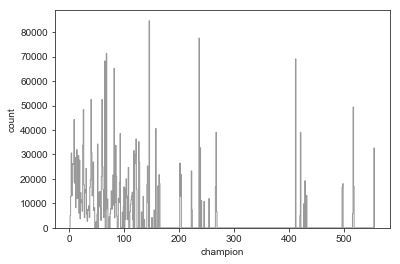

In [20]:
sns.set_style('ticks')
champ_sum = np.concatenate((lol_df['blue_champs0'],lol_df['blue_champs1'],lol_df['blue_champs2'],
            lol_df['blue_champs3'],lol_df['blue_champs4'],lol_df['red_champs0'],
            lol_df['red_champs1'],lol_df['red_champs2'],lol_df['red_champs3'],
            lol_df['red_champs4']),axis=None)

sns.distplot(champ_sum,bins=555,kde=False,hist_kws={'histtype':'step','color' :'Black'})
plt.xlabel('champion')
plt.ylabel('count')
plt.show()

## Define preprocess functions

In [21]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [22]:
#target_name to name tfrecords file and the target_df column to call
#for now don't keep all possible targets in target_df
#target_df selection is made with the preprocess_target function call
def convert_to_tfrecords(filename, examples, target_df,target_name):
    # open the TFRecords file
    writer = tf.python_io.TFRecordWriter(filename)
    
    blue_hero_array = np.array(examples['blue_champs'])
    red_hero_array = np.array(examples['red_champs'])
    target_array = np.array(target_df[target_name])
    
    for i in range(len(blue_hero_array[:])):
        # print how many games are saved every 10000 games
        if not i % 10000:
            print('Train data: %d/%d' % (i, len(examples)))
            sys.stdout.flush()
            
        # Load the hero_array
        blue_champs = blue_hero_array[:][i].tostring()
        red_champs = red_hero_array[:][i].tostring()
        target = target_array[i]
        
        # Create a feature
        if target_name=='blue_win':
            feature = {'blue_champs': _bytes_feature(tf.compat.as_bytes(blue_champs)),
                   'red_champs': _bytes_feature(tf.compat.as_bytes(red_champs)),
                   'targets': _int64_feature(target)}
        else:
            feature = {'blue_champs': _bytes_feature(tf.compat.as_bytes(blue_champs)),
                   'red_champs': _bytes_feature(tf.compat.as_bytes(red_champs)),
                   'targets': _float_feature(target)}
        # Create an example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature=feature))
    
        # Serialize to string and write on the file
        writer.write(example.SerializeToString())
    
    writer.close()
    sys.stdout.flush()

In [23]:
def preprocess_features(lol_df):
    """Take lol_df and create a dataframe containing only the features for our model
            Args: 
                lol_df: Dataframe containing lol training and test data
            returns: 
                processed_df: pandas DataFrame containing only feature columns
    """
    
    #Use arrays of champs for each team as features rather than each hero
    #individually to help model fit?
    #This is an attempt to make the model more similar to the movie review
    #text analysis example in the Google ML Crash Course
    processed_df = pd.DataFrame()
    
    processed_df['blue_champs'] = list(np.array(lol_df.loc[:,['blue_champs0',
                                                'blue_champs1','blue_champs2',
                                                'blue_champs3','blue_champs4']]).astype(int))
    processed_df['red_champs'] = list(np.array(lol_df.loc[:,['red_champs0',
                                    'red_champs1','red_champs2',
                                    'red_champs3','red_champs4']]).astype(int))

    return processed_df
    
def preprocess_targets_win(lol_df):
    """Take lol_df and create a dataframe containing only the targets for our model. (blue_win here)
            Args: 
                lol_df: Dataframe containing lol training and test data
            returns: 
                target_df: pandas DataFrame containing only the target column
    """
    target_df = pd.DataFrame()
    target_df['blue_win'] = lol_df['blue_win']
    
    return target_df

def preprocess_targets_gold(lol_df):
    """Take lol_df and create a dataframe containing only the targets for our model 
        (normalized gold difference in this case)
            Args: 
                lol_df: Dataframe containing lol training and test data
            returns: 
                target_df: pandas DataFrame containing only the target column (gold_diff)
    """
    target_df = pd.DataFrame()
    target_df['gold_diff'] = (lol_df['blue_gold']-lol_df['red_gold'])/(lol_df['blue_gold']+lol_df['red_gold'])
    target_df['gold_diff'] = (target_df['gold_diff']-target_df['gold_diff'].mean())/target_df['gold_diff'].std()
    return target_df

#this can be easily modified for baron, dragon, or inhib kills
def preprocess_targets_towerkills(lol_df):
    """Take lol_df and create a dataframe containing only the targets for our model 
        (normalized tower_kill difference in this case)
            Args: 
                lol_df: Dataframe containing lol training and test data
            returns: 
                target_df: pandas DataFrame containing only the target column (tower_kills)
    """
    tower_kills = np.array([])
    for blue_tow,red_tow in zip(lol_df['blue_tower_kills'],lol_df['red_tower_kills']):
        if blue_tow!=0 or red_tow!=0:
            tower_kills = np.append(tower_kills,(blue_tow-red_tow)/(blue_tow+red_tow))
        else:
            tower_kills = np.append(tower_kills,0)

    target_df = pd.DataFrame()
    target_df['tower_kills'] = tower_kills
    
    return target_df

### Visualize data for each set

In [24]:
plotting_df = lol_df

display.display(plotting_df.iloc[:train_len,:].describe())
display.display(plotting_df.iloc[train_len:train_len+test_len,:].describe())
display.display(plotting_df.iloc[train_len+test_len:,:].describe())

,blue_win,blue_gold,red_gold,blue_tower_kills,red_tower_kills,blue_inhibitor_kills,red_inhibitor_kills,blue_dragon_kills,red_dragon_kills,blue_baron_kills,...,blue_champs0,red_champs0,blue_champs1,red_champs1,blue_champs2,red_champs2,blue_champs3,red_champs3,blue_champs4,red_champs4
count,192813.000000,192813.000000,192813.000000,192813.000000,192813.000000,192813.000000,192813.000000,192813.000000,192813.000000,192813.000000,...,192813.000000,192813.000000,192813.000000,192813.000000,192813.00000,192813.000000,192813.000000,192813.000000,192813.000000,192813.000000
mean,0.484008,49919.690840,50336.863256,5.117440,5.252457,0.821599,0.852105,1.366158,1.564713,0.428763,...,130.034360,128.772827,131.253645,130.777785,130.87214,130.648084,130.657876,131.339484,129.879925,128.286366
std,0.499745,15123.023933,15284.502801,3.708032,3.742708,1.091140,1.095318,1.234386,1.287411,0.620760,...,135.052642,134.250160,135.809174,135.684361,135.88169,135.814460,135.483761,136.173608,134.923714,134.003945
min,0.000000,3520.000000,3585.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,40203.000000,40525.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,39.000000,39.000000,39.000000,39.000000,39.00000,39.000000,39.000000,39.000000,39.000000,39.000000
50%,0.000000,50578.000000,51051.000000,5.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,84.000000,84.000000,84.000000,84.000000,84.00000,84.000000,84.000000,84.000000,84.000000,84.000000
75%,1.000000,60068.000000,60649.000000,9.000000,9.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,154.000000,150.000000,157.000000,157.000000,157.00000,157.000000,157.000000,157.000000,157.000000,145.000000
max,1.000000,141001.000000,122758.000000,11.000000,11.000000,13.000000,10.000000,7.000000,7.000000,5.000000,...,555.000000,555.000000,555.000000,555.000000,555.00000,555.000000,555.000000,555.000000,555.000000,555.000000


,blue_win,blue_gold,red_gold,blue_tower_kills,red_tower_kills,blue_inhibitor_kills,red_inhibitor_kills,blue_dragon_kills,red_dragon_kills,blue_baron_kills,...,blue_champs0,red_champs0,blue_champs1,red_champs1,blue_champs2,red_champs2,blue_champs3,red_champs3,blue_champs4,red_champs4
count,55090.000000,55090.000000,55090.000000,55090.000000,55090.000000,55090.000000,55090.000000,55090.000000,55090.000000,55090.000000,...,55090.000000,55090.000000,55090.000000,55090.000000,55090.000000,55090.000000,55090.000000,55090.000000,55090.000000,55090.000000
mean,0.481340,49827.123543,50245.590597,5.105718,5.238882,0.816319,0.843819,1.365674,1.559031,0.427119,...,129.966564,130.037412,130.899909,129.089472,131.381539,130.082356,130.446978,129.944872,129.384480,127.364404
std,0.499656,15108.392482,15258.845447,3.701648,3.737566,1.087742,1.089725,1.234348,1.283659,0.618940,...,135.413556,134.882842,135.704482,134.448433,136.374850,135.461840,135.503637,135.082660,135.121528,133.347407
min,0.000000,3495.000000,3575.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,40135.000000,40416.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,38.000000
50%,0.000000,50495.500000,50952.000000,5.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,84.000000,84.000000,84.000000,83.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
75%,1.000000,60018.000000,60580.000000,9.000000,9.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,154.000000,157.000000,157.000000,154.000000,157.000000,154.000000,157.000000,154.000000,154.000000,145.000000
max,1.000000,213912.000000,173857.000000,11.000000,11.000000,13.000000,10.000000,14.000000,7.000000,4.000000,...,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000


,blue_win,blue_gold,red_gold,blue_tower_kills,red_tower_kills,blue_inhibitor_kills,red_inhibitor_kills,blue_dragon_kills,red_dragon_kills,blue_baron_kills,...,blue_champs0,red_champs0,blue_champs1,red_champs1,blue_champs2,red_champs2,blue_champs3,red_champs3,blue_champs4,red_champs4
count,27545.000000,27545.000000,27545.000000,27545.000000,27545.000000,27545.000000,27545.000000,27545.000000,27545.000000,27545.000000,...,27545.000000,27545.000000,27545.000000,27545.000000,27545.000000,27545.000000,27545.000000,27545.000000,27545.000000,27545.000000
mean,0.491523,50061.611835,50311.495444,5.178145,5.209766,0.840516,0.843311,1.378835,1.563623,0.434271,...,129.749646,129.998620,131.026647,130.772118,131.069341,130.323834,131.615139,130.942893,129.419495,129.380868
std,0.499937,15175.564240,15328.697774,3.709327,3.740619,1.102244,1.098472,1.231955,1.288969,0.624299,...,135.188856,135.960656,135.076778,135.387833,135.427324,135.503107,136.217908,136.198530,134.471231,135.350061
min,0.000000,3640.000000,3575.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,40331.000000,40391.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
50%,0.000000,50745.000000,51044.000000,5.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
75%,1.000000,60347.000000,60746.000000,9.000000,9.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,154.000000,150.000000,157.000000,157.000000,157.000000,154.000000,157.000000,157.000000,157.000000,150.000000
max,1.000000,141001.000000,122758.000000,11.000000,11.000000,11.000000,11.000000,7.000000,7.000000,4.000000,...,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000


### Export win tfrecord

In [25]:
tier = 'mix_tier'
training_frac = 0.7
train_len = int(len(lol_df) * training_frac)
test_len = int((len(lol_df) - train_len)/1.5)
validation_len = len(lol_df) - train_len - test_len

train_features = preprocess_features(lol_df.iloc[:train_len,:])
train_targets = preprocess_targets_win(lol_df.iloc[:train_len,:])

test_features = preprocess_features(lol_df.iloc[train_len:train_len+test_len,:])
test_targets = preprocess_targets_win(lol_df.iloc[train_len:train_len+test_len,:])

validation_features = preprocess_features(lol_df.iloc[train_len+test_len:,:])
validation_targets = preprocess_targets_win(lol_df.iloc[train_len+test_len:,:])

target_name='blue_win'
convert_to_tfrecords(os.path.join('LOL_data',tier,'lol_training_data', 
                     target_name+'_lol_training_data.tfrecords'),
                     train_features,
                     train_targets,
                     target_name=target_name)

convert_to_tfrecords(os.path.join('LOL_data',tier,'lol_test_data', 
                     target_name+'_lol_test_data.tfrecords'),
                     test_features,
                     test_targets,
                     target_name=target_name)

convert_to_tfrecords(os.path.join('LOL_data',tier,'lol_validation_data',
                     target_name+'_lol_validation_data.tfrecords'),
                     validation_features,
                     validation_targets,
                     target_name=target_name)


Train data: 0/192813
Train data: 10000/192813
Train data: 20000/192813
Train data: 30000/192813
Train data: 40000/192813
Train data: 50000/192813
Train data: 60000/192813
Train data: 70000/192813
Train data: 80000/192813
Train data: 90000/192813
Train data: 100000/192813
Train data: 110000/192813
Train data: 120000/192813
Train data: 130000/192813
Train data: 140000/192813
Train data: 150000/192813
Train data: 160000/192813
Train data: 170000/192813
Train data: 180000/192813
Train data: 190000/192813
Train data: 0/55090
Train data: 10000/55090
Train data: 20000/55090
Train data: 30000/55090
Train data: 40000/55090
Train data: 50000/55090
Train data: 0/27545
Train data: 10000/27545
Train data: 20000/27545


### Export gold tfrecord

In [26]:
tier = 'mix_tier'
training_frac = 0.7
train_len = int(len(lol_df) * training_frac)
test_len = int((len(lol_df) - train_len)/1.5)
validation_len = len(lol_df) - train_len - test_len

train_features = preprocess_features(lol_df.iloc[:train_len,:])
train_targets = preprocess_targets_gold(lol_df.iloc[:train_len,:])

test_features = preprocess_features(lol_df.iloc[train_len:train_len+test_len,:])
test_targets = preprocess_targets_gold(lol_df.iloc[train_len:train_len+test_len,:])

validation_features = preprocess_features(lol_df.iloc[train_len+test_len:,:])
validation_targets = preprocess_targets_gold(lol_df.iloc[train_len+test_len:,:])

target_name='gold_diff'
convert_to_tfrecords(os.path.join('LOL_data',tier,'lol_training_data', 
                     target_name+'_lol_training_data.tfrecords'),
                     train_features,
                     train_targets,
                     target_name=target_name)

convert_to_tfrecords(os.path.join('LOL_data',tier,'lol_test_data', 
                     target_name+'_lol_test_data.tfrecords'),
                     test_features,
                     test_targets,
                     target_name=target_name)

convert_to_tfrecords(os.path.join('LOL_data',tier,'lol_validation_data',
                     target_name+'_lol_validation_data.tfrecords'),
                     validation_features,
                     validation_targets,
                     target_name=target_name)


Train data: 0/192813
Train data: 10000/192813
Train data: 20000/192813
Train data: 30000/192813
Train data: 40000/192813
Train data: 50000/192813
Train data: 60000/192813
Train data: 70000/192813
Train data: 80000/192813
Train data: 90000/192813
Train data: 100000/192813
Train data: 110000/192813
Train data: 120000/192813
Train data: 130000/192813
Train data: 140000/192813
Train data: 150000/192813
Train data: 160000/192813
Train data: 170000/192813
Train data: 180000/192813
Train data: 190000/192813
Train data: 0/55090
Train data: 10000/55090
Train data: 20000/55090
Train data: 30000/55090
Train data: 40000/55090
Train data: 50000/55090
Train data: 0/27545
Train data: 10000/27545
Train data: 20000/27545
